In [11]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import tensorflow as tf
import pandas as pd
from pandas import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from statsmodels.tsa.stattools import adfuller
import numpy as np

Using TensorFlow backend.


In [12]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(df, lag=1):
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [13]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [14]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return np.exp(yhat)

In [15]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [16]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [33]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [34]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [35]:
covid=pd.read_csv("MasterProjectDatasets/covid_19_data.csv")

In [36]:
covid = covid[covid["ObservationDate"] <= '07/01/2020']
covid['ObservationDate'] = pd.to_datetime(covid['ObservationDate'].astype(str), errors='coerce')

In [37]:
covid = covid[['ObservationDate', 'Confirmed']]

In [38]:
grouped_date=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum'})

In [39]:
grouped_date

,Confirmed
ObservationDate,
2020-01-22,555.0
2020-01-23,653.0
2020-01-24,941.0
2020-01-25,1438.0
2020-01-26,2118.0
...,...
2020-06-27,9979535.0
2020-06-28,10145791.0
2020-06-29,10302151.0


In [40]:
result = adfuller(grouped_date['Confirmed'])

In [41]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.568106
p-value: 0.997759
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


In [42]:
grouped3 = np.log(grouped_date)
grouped3 = grouped3.dropna()

In [43]:
result = adfuller(grouped3['Confirmed'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.672597
p-value: 0.445284
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.577


In [44]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(grouped3['Confirmed'], 1)
supervised_values = supervised.values

In [45]:
# split data into train and test-sets
train, test = supervised_values[0:-32], supervised_values[-32:]

In [46]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [47]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 2)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-1.0017759 ],
       [-0.9684256 ],
       [-0.8836254 ],
       [-0.7763426 ],
       [-0.7056275 ],
       [-0.6355571 ],
       [-0.57544   ],
       [-0.46767372],
       [-0.4288953 ],
       [-0.3766262 ],
       [-0.33675203],
       [-0.2980662 ],
       [-0.2357769 ],
       [-0.19619827],
       [-0.15829933],
       [-0.12708718],
       [-0.10333738],
       [-0.08046558],
       [-0.06369063],
       [-0.0473146 ],
       [-0.03378812],
       [-0.02361939],
       [-0.02073197],
       [ 0.03274224],
       [ 0.05813191],
       [ 0.0669242 ],
       [ 0.07379958],
       [ 0.07981605],
       [ 0.0852052 ],
       [ 0.08699926],
       [ 0.08859017],
       [ 0.09034088],
       [ 0.09479551],
       [ 0.09613465],
       [ 0.09768675],
       [ 0.0998401 ],
       [ 0.10234781],
       [ 0.10573205],
       [ 0.10916519],
       [ 0.11371616],
       [ 0.11928707],
       [ 0.12393583],
       [ 0.12965794],
       [ 0.13481033],
       [ 0.14075923],
       [ 0

In [48]:
raw_values = grouped_date['Confirmed'].values

In [55]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(grouped3['Confirmed'], yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	if(len(train) + i+1)<162:
		expected = raw_values[len(train) + i + 1]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=6924777.581805, Expected=6265852.000000
Day=2, Predicted=6599822.016692, Expected=6386364.000000
Day=3, Predicted=6483484.539238, Expected=6508635.000000
Day=4, Predicted=6534064.776678, Expected=6632985.000000
Day=5, Predicted=6628865.558238, Expected=6770170.000000
Day=6, Predicted=6741550.612498, Expected=6896917.000000
Day=7, Predicted=6869870.598104, Expected=7010582.000000
Day=8, Predicted=6993311.789037, Expected=7119002.000000
Day=9, Predicted=7106813.809392, Expected=7242313.000000
Day=10, Predicted=7214641.029481, Expected=7360239.000000
Day=11, Predicted=7332600.778893, Expected=7514481.000000
Day=12, Predicted=7447390.076055, Expected=7632802.000000
Day=13, Predicted=7590133.615842, Expected=7766952.000000
Day=14, Predicted=7709159.576085, Expected=7900924.000000
Day=15, Predicted=7838453.475452, Expected=8034504.000000
Day=16, Predicted=7967910.756318, Expected=8173940.000000
Day=17, Predicted=8097630.000122, Expected=8349950.000000
Day=18, Predicted=82319

In [56]:
model_train=grouped_date.iloc[:int(grouped_date.shape[0]*0.80)]
valid=grouped_date.iloc[int(grouped_date.shape[0]*0.80):]
y_pred=valid.copy()

In [58]:
import plotly.graph_objects as go
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=predictions,
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases LSTM Model",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Test RMSE: 121631.293
Test MAE: 95741.046


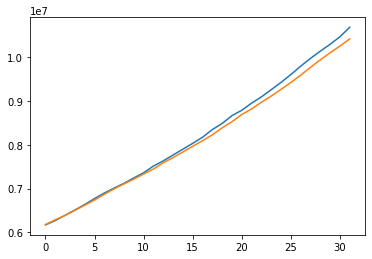

In [50]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-32:], predictions))
mae = mean_absolute_error(raw_values[-32:], predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-32:])
pyplot.plot(predictions)
pyplot.show()